# Project Supervised Regression 

---

## MEDICAL COST

### GOAL
Memprediksi biaya asuransi kesehatan berdasarkan usia, BMI, kebiasaan merokok, dan faktor lainnya.

#### Step by Step

1. Problem Statement → Menentukan masalah yang ingin diselesaikan

2. Data Collection → Mengumpulkan data dari database

3. EDA → Mengeksplorasi dan memahami data, mencari pola, tren, dan hubungan antar variabel dengan cara membuat visualisasi

4. Data Cleaning → Menangani masalah data seperti missing values, duplikasi, outlier

5. Feature Engineering → Membuat fitur baru atau memodifikasi fitur yang ada supaya lebih relevan untuk model.

6. Data Splitting → Membagi dataset menjadi train set dan test set untuk di latih dan di uji oleh model

7. Modelling (Machine Learning) → Membangun model prediksi menggunakan algoritma yang sesuai.

8. Model Evaluation → Mengukur performa model menggunakan metrik tertentu, misal RMSE, MAE, atau R² untuk regresi.

9. Hyperparameter Tuning → Mengoptimalkan parameter model agar performanya lebih baik.

10. Documentation 

---

#### 1. Issue
1. Biaya asuransi kesehatan tiap individu berbeda dan dipengaruhi banyak faktor seperti age, bmi, dan smoker

2. Dibutuhkan model prediksi agar perhitungan lebih akurat dan bisa membantu pengambilan keputusan.

#### 2. Data Collection


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

insurance  = pd.read_csv("insurance.csv")
print(insurance.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


### Columns

- Charges: Medical Cost

- Age: Usia 

- Sex: Gender (male or female)

- BMI: Perhitungan apakah bentuk tubuh ideal atau tidak

- Smoker: Perokok

- Children: Jumlah anak yang ditanggungoleh asuransi kesehatan

- Region: Wilayah tempat tinggal penerima asuransi (Nortwest, Northwast, Southwest, Southeast)

#### 3. Explatory Data Analysis

In [195]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [196]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


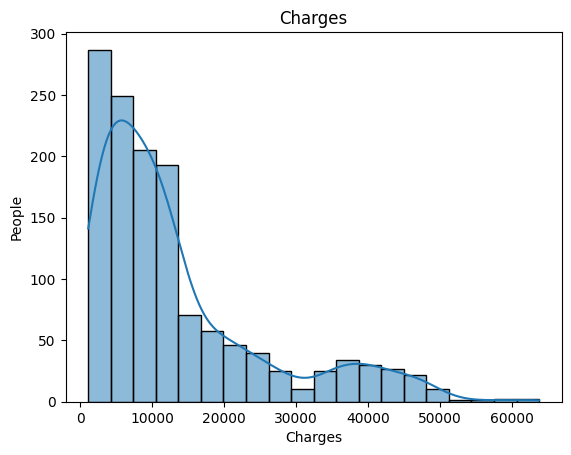

In [197]:
# Charges Distribution
sns.histplot(insurance['charges'], bins=20, kde=True)
plt.title("Charges")
plt.xlabel("Charges")
plt.ylabel("People")
plt.show()

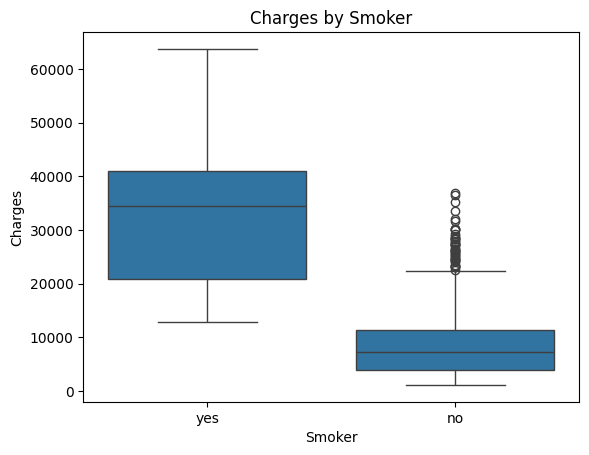

In [198]:
# Charges by Smoker (boxplot)
sns.boxplot(x='smoker', y='charges', data=insurance)
plt.title("Charges by Smoker")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


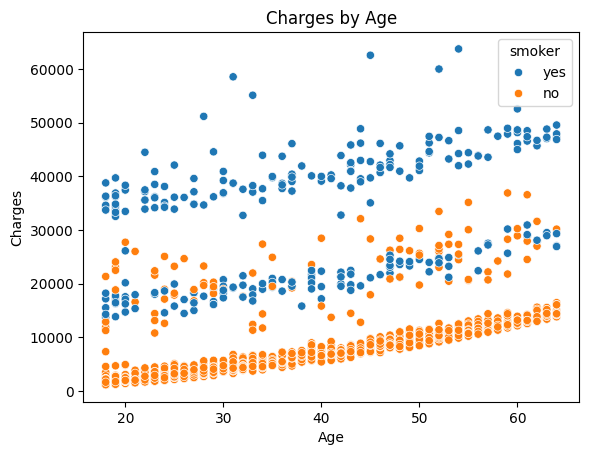

In [199]:
# Charges by age (scatterplot)
sns.scatterplot(x='age', y='charges', hue='smoker', data=insurance)
plt.title("Charges by Age")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

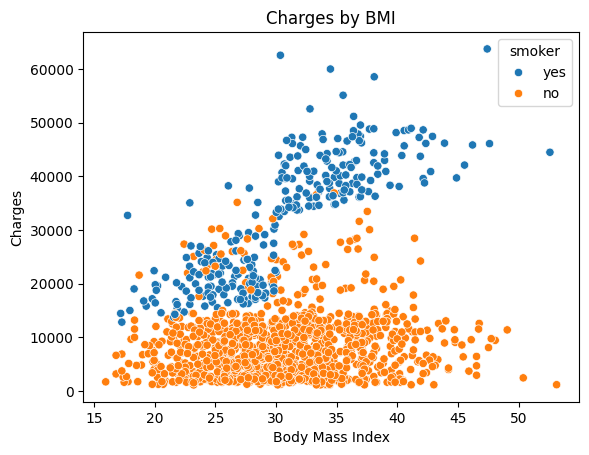

In [200]:
# Charges by BMI (scatterplot)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=insurance)
plt.title("Charges by BMI")
plt.xlabel("Body Mass Index")
plt.ylabel("Charges")
plt.show()

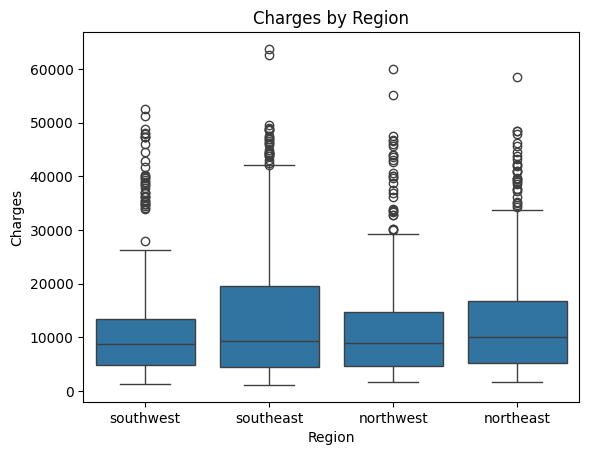

In [201]:
# Charges by Region (barplot)
insurance_raw = pd.read_csv("insurance.csv")
sns.boxplot(x='region', y='charges', data=insurance_raw)
plt.title("Charges by Region")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()

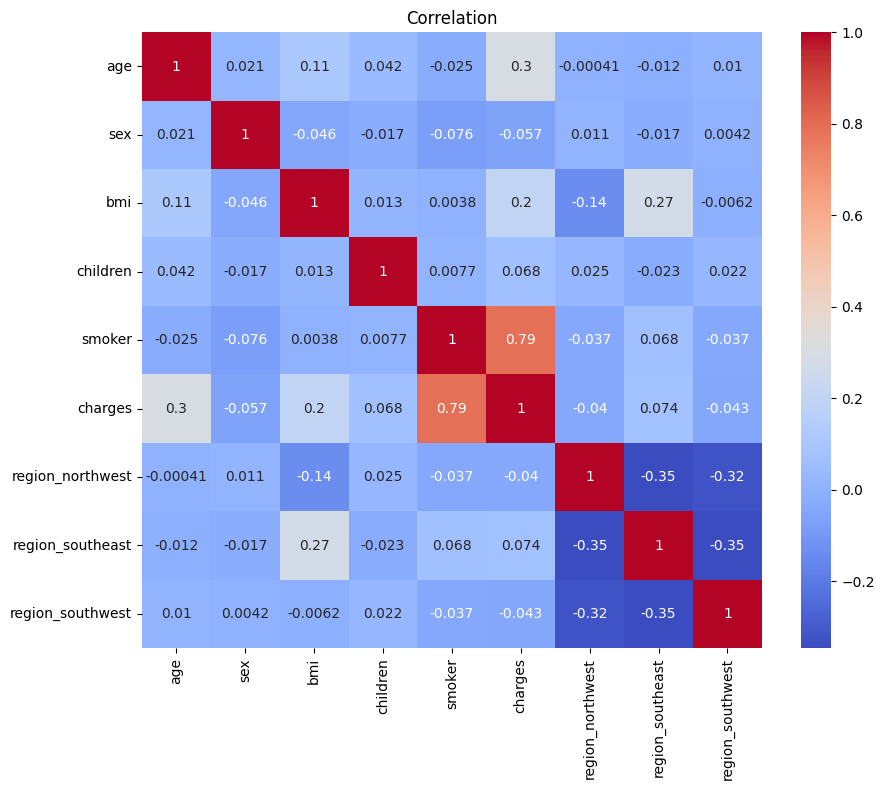

In [202]:
# Correlation
insurance_encoded = insurance.copy()

insurance_encoded['sex'] = insurance_encoded['sex'].map({'male':0, 'female':1})
insurance_encoded['smoker'] = insurance_encoded['smoker'].map({'no':0, 'yes':1})

insurance_encoded = pd.get_dummies(insurance_encoded, columns=['region'], drop_first=True)

cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
        'region_northwest', 'region_southeast', 'region_southwest']
plt.figure(figsize=(10,8))
sns.heatmap(insurance_encoded[cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation')
plt.show()


#### 4. Data Cleaning 

In [203]:
print(insurance.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [204]:
print(insurance.duplicated().sum())


1


In [205]:
insurance.drop_duplicates(inplace=True)

#### 5. Feature Engineering

In [206]:
# Encoding kolom kategorikal (sex, smoker)
label_cols = ['sex', 'smoker']
encoders = {}  

for col in label_cols:
    le = LabelEncoder()
    insurance[col] = le.fit_transform(insurance[col])
    encoders[col] = le

In [207]:
# One Hot Encoding for Region
insurance = pd.get_dummies(insurance, columns=['region'], drop_first=True)

In [208]:
# Tambah fitur BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

insurance['bmi_category'] = insurance['bmi'].apply(bmi_category)


In [209]:
def age_group(age):
    if age < 18:
        return "Children"
    elif age < 40:
        return "Adult"
    elif age < 60:
        return "MiddleAge"
    else:
        return "Senior"

insurance['age_group'] = insurance['age'].apply(age_group)

In [210]:
# One Hot Encode 
insurance = pd.get_dummies(insurance, columns=['bmi_category'], drop_first=True, dtype=int)
insurance = pd.get_dummies(insurance, columns=['age_group'], drop_first=True, dtype=int)

In [211]:
# Interaction Features
insurance['bmi_smoker'] = insurance['bmi'] * insurance['smoker']
insurance['age_smoker'] = insurance['age'] * insurance['smoker']

#### 6. Data Splitting

In [212]:
X = insurance.drop('charges', axis = 1 )
y = insurance['charges']
X = pd.get_dummies(X, drop_first=True)  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

In [213]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 7. Modelling (Machine Learning)

In [214]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"=== {name} ===")
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²  :", r2_score(y_test, y_pred))
    print()

=== Linear Regression ===
MAE : 2821.101924363905
RMSE: 4558.761599462544
R²  : 0.8869027401670616

=== Random Forest ===
MAE : 2702.5681197242543
RMSE: 4746.8069978958965
R²  : 0.8773799559059241

=== KNN ===
MAE : 2938.801368578358
RMSE: 4939.115768091334
R²  : 0.8672432134530688



##### Summary
| Model               | Akurasi |
| ------------------- | ------- |
| Logistic Regression | \~88%   |
| Random Forest       | \~87%   |
| KNN                 | \~86%   |

Random Forest memiliki akurasi tertinggi di antara ketiga model.

#### 8. Model Evaluation

In [218]:
best_model = LinearRegression()
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

#### 9. Hyperparameter Tuning

In [222]:
param_grid = {
    'fit_intercept': [True, False],   # apakah mau ada intercept atau tidak
    'positive': [True, False]         # apakah koefisien semua harus positif
}

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (R²):", grid_search.best_score_)

Best Parameters: {'fit_intercept': True, 'positive': False}
Best Score (R²): 0.828833617157734


## Insight

1. Smoker sangat berpengaruh: Perokok memiliki biaya asuransi jauh lebih tinggi dibanding non-smoker.

2. Usia memengaruhi biaya: Semakin tua usia seseorang, semakin tinggi biaya asuransinya.

3. BMI berpengaruh signifikan: Individu dengan BMI tinggi (overweight/obese) cenderung memiliki biaya asuransi lebih besar.

4. Region dan jumlah anak kurang berpengaruh: Faktor wilayah dan jumlah anak tidak berdampak signifikan terhadap biaya asuransi.

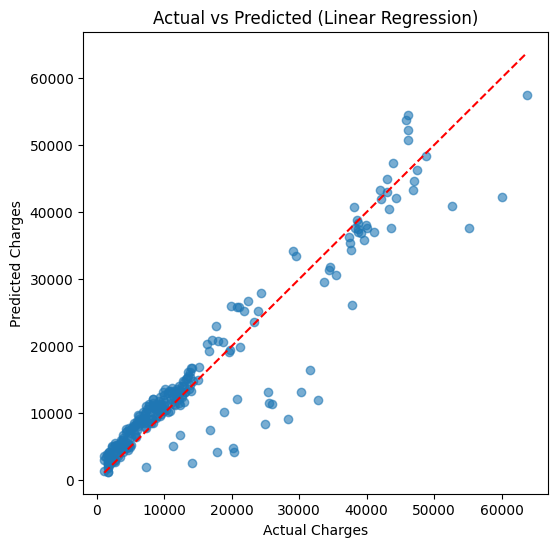

In [220]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Charges") 
plt.ylabel("Predicted Charges") 
plt.title("Actual vs Predicted (Linear Regression)") 
plt.show()